## Calculating likelihoods

In [1]:
import matplotlib.pyplot as plt
import corner as corner
import pandas as pd
import numpy as np
import h5py
import torch
import time
from scipy.special import logsumexp

import sys

sys.path.append('../')
from populations.bbh_models import get_models
import populations.bbh_models as read_models
from populations.utils.flow import NFlow
from populations.Flowsclass_dev import FlowModel
from populations import gw_obs

from sample import sample

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


glasflow is using its own internal version of nflows


In [2]:
params = ['mchirp','q', 'chieff', 'z']
chi_b = [0.0,0.1,0.2,0.5]
alpha = [0.2,0.5,1.,2.,5.]
channel ='GC'
file_path='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
gw_path = '/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/simulated_events_processed/2_chi00'
observations, obsdata, p_theta, events = gw_obs.generate_observations(params, gw_path, \
                                            100, 'posteriors', None)

model_names, flow = read_models.get_models(file_path, [channel], params, use_flows=True, device='cpu', no_bins=[5])
model_names, KDE = read_models.get_models(file_path, [channel], params, use_flows=False, device='cpu')

100%|██████████| 20/20 [00:08<00:00,  2.22it/s]


## Likelihoods In sampling

In [3]:
#inputs: x, data, pop_models, submodels_dict, channels, use_flows
hyperparams = list(set([x.split('/', 1)[1] for x in model_names]))
Nhyper = np.max([len(x.split('/')) for x in hyperparams])
channels = sorted(list(set([x.split('/')[0] for x in model_names])))

# construct dict that relates submodels to their index number
submodels_dict = {} #dummy index dict keys:0,1,2,3, items: particular models
ctr=0 #associates with either chi_b or alpha (0 or 1)
while ctr < Nhyper:
    submodels_dict[ctr] = {}
    hyper_set = sorted(list(set([x.split('/')[ctr] for x in hyperparams])))
    for idx, model in enumerate(hyper_set): #idx associates with 0,1,2,3,(4) keys
        submodels_dict[ctr][idx] = model
    ctr += 1

In [4]:
flow_path="/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/flows_271023/flows_271023/flow_models/"
for chnl in ['CE']: flow[chnl].load_model(flow_path, chnl)

In [5]:
oneobs = np.array([[obsdata[0,0,:]]])

In [6]:
oneobs

array([[[30.87591522,  0.8667151 ,  0.38811157,  0.19688377]]])

In [7]:
lnlike_flow=np.zeros((4,5))
for chibid in range(4):
    for alphaid in range(5):
        print((chibid,alphaid))
        lnlike_flow[chibid,alphaid]=sample.lnlike([chibid,alphaid],oneobs, flow, submodels_dict, ['CE'], use_flows=True, prior_pdf=np.array([p_theta[0][0]]))

(0, 0)
likelihood per samp
[[-7.77151442]]
likelihood
[-7.77151442]
lnprob
[-7.77151442]
(lnprob-np.log(alpha)).sum()
-7.771514415740967
(0, 1)
likelihood per samp
[[-10.8835659]]
likelihood
[-10.8835659]
lnprob
[-10.8835659]
(lnprob-np.log(alpha)).sum()
-10.883565902709961
(0, 2)
likelihood per samp
[[-13.45147514]]
likelihood
[-13.45147514]
lnprob
[-13.45147514]
(lnprob-np.log(alpha)).sum()
-13.451475143432617
(0, 3)
likelihood per samp
[[-16.80575562]]
likelihood
[-16.80575562]
lnprob
[-16.80575562]
(lnprob-np.log(alpha)).sum()
-16.805755615234375
(0, 4)
likelihood per samp
[[-26.23421288]]
likelihood
[-26.23421288]
lnprob
[-26.23421288]
(lnprob-np.log(alpha)).sum()
-26.23421287536621
(1, 0)
likelihood per samp
[[-9.15244007]]
likelihood
[-9.15244007]
lnprob
[-9.15244007]
(lnprob-np.log(alpha)).sum()
-9.152440071105957
(1, 1)
likelihood per samp
[[-11.95845604]]
likelihood
[-11.95845604]
lnprob
[-11.95845604]
(lnprob-np.log(alpha)).sum()
-11.958456039428711
(1, 2)
likelihood per sam

In [50]:
lnlike_flow

array([[ -4292.97294826,  -4022.5101641 ,  -4214.04983827,
         -4573.01851814,  -4589.85859623],
       [ -4935.70702129,  -4403.3717424 ,  -4560.07318776,
         -4799.92852669,  -4634.53701267],
       [ -6322.15376045,  -5148.05372662,  -4984.40036835,
         -5172.62399949,  -4918.90886967],
       [-10395.0848944 ,  -7584.83520434,  -6569.5972193 ,
         -6159.11821421,  -5480.25013067]])

Text(0.5, 1.0, 'CE channel likelihoods (flow)')

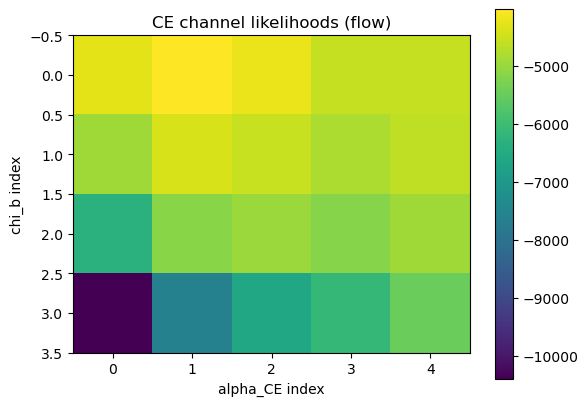

In [15]:
plt.imshow(lnlike_flow)
plt.xlabel('alpha_CE index')
plt.ylabel('chi_b index')
plt.colorbar()
plt.title('CE channel likelihoods (flow)')

In [16]:
flow['CE'].flow.get_logprob(np.array([[[10.,0.9,0.1,0.1]]]), flow['CE'].map_obs(np.array([[[10.,0.9,0.1,0.1]]])), flow['CE'].mappings, np.array([[[0.,0.2]]]))

array([[-8.523532]], dtype=float32)

In [17]:
np.log(KDE['CE']['chi00']['alpha02'](np.array([[[10.,0.9,0.1,0.1]]])))

array([-9.45932365])

In [10]:
from functools import reduce
import operator
def getFromDict(dataDict, mapList):
    return reduce(operator.getitem, mapList, dataDict)

In [11]:
lnlike_kde=np.zeros((4,5))
for chibid in range(4):
    for alphaid in range(5):
        print((chibid,alphaid))
        lnlike_kde[chibid,alphaid]=sample.lnlike([chibid,alphaid,1.],oneobs, KDE, submodels_dict, ['CE'], use_flows=False, prior_pdf=[p_theta[0][0]])

(0, 0)
likelihood per samp
[-7.77606302]
likelihood
[-7.77606302]
lnprob
[-7.77606302]
(lnprob-np.log(alpha)).sum()
-7.776063023456021
(0, 1)
likelihood per samp
[-16.32652617]
likelihood
[-16.32652617]
lnprob
[-16.32652617]
(lnprob-np.log(alpha)).sum()
-16.326526167587765
(0, 2)
likelihood per samp
[-20.66391493]
likelihood
[-20.66391493]
lnprob
[-20.66391493]
(lnprob-np.log(alpha)).sum()
-20.66391493123658
(0, 3)
likelihood per samp
[-47.62462125]
likelihood
[-47.62462125]
lnprob
[-47.62462125]
(lnprob-np.log(alpha)).sum()
-47.62462124788823
(0, 4)
likelihood per samp
[-158.84429246]
likelihood
[-115.12925465]
lnprob
[-115.12925465]
(lnprob-np.log(alpha)).sum()
-115.12925464970229
(1, 0)
likelihood per samp
[-12.44147871]
likelihood
[-12.44147871]
lnprob
[-12.44147871]
(lnprob-np.log(alpha)).sum()
-12.441478707583384
(1, 1)
likelihood per samp
[-13.29927609]
likelihood
[-13.29927609]
lnprob
[-13.29927609]
(lnprob-np.log(alpha)).sum()
-13.299276085785001
(1, 2)
likelihood per samp
[-1

In [13]:
lnlike_flow

array([[ -7.77151442, -10.8835659 , -13.45147514, -16.80575562,
        -26.23421288],
       [ -9.15244007, -11.95845604, -14.44664764, -17.3794632 ,
        -25.8398037 ],
       [-10.29758549, -12.97566032, -15.12759972, -17.95720673,
        -25.77956581],
       [-64.4919281 , -34.33011246, -18.82589912, -15.10786438,
        -14.64742279]])

In [12]:
lnlike_kde

array([[  -7.77606302,  -16.32652617,  -20.66391493,  -47.62462125,
        -115.12925465],
       [ -12.44147871,  -13.29927609,  -15.25559224,  -52.47451518,
        -115.12925465],
       [ -11.64940441,  -14.14380083,  -15.23583053,  -51.20191225,
         -73.43573679],
       [ -28.36124417,  -34.02832971,  -32.02429806,  -31.91979288,
         -40.20437791]])

Text(0.5, 1.0, 'CE channel likelihoods (KDEs)')

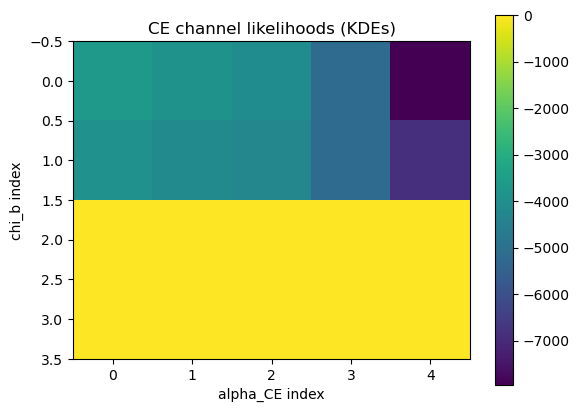

In [21]:
plt.imshow(lnlike_kde)
plt.xlabel('alpha_CE index')
plt.ylabel('chi_b index')
plt.colorbar()
plt.title('CE channel likelihoods (KDEs)')

In [15]:
lnlike_kde

array([[ -488.54896481,  -516.01045514,  -497.21744547,  -580.29421382,
         -786.29323308],
       [ -517.44113865,  -539.3906847 ,  -521.00342875,  -575.61471784,
         -720.9136174 ],
       [ -638.6766879 ,  -624.86668284,  -599.60617914,  -649.87875854,
         -752.67508215],
       [-2372.87555011, -2421.31486477, -2474.83763468, -2571.90109638,
        -2591.77152278]])

In [17]:
flow['CE'](obsdata, np.array([0,4]), prior_pdf=p_theta)

array([  -9.20302148,   -8.78135162,   -6.19423043,   -7.75944685,
        -28.28176917,   -8.74912355,  -10.40066797,  -28.72386682,
        -28.82096547,  -11.99128996,  -11.28014389,   -9.6537231 ,
         -7.52794299,   -8.84011782,   -9.93582466,  -12.92557307,
        -13.54554061,   -6.4527987 ,   -7.73029182,  -10.17206779,
         -8.60403119,  -14.18859681,   -8.18808432,   -8.50550673,
        -10.34154094,   -8.74545253,  -15.14677686,  -25.0078318 ,
        -22.61748219,   -6.41279088,   -5.28287875,  -10.67451398,
         -6.34738207,   -5.69846835,   -8.29271577,   -7.9853818 ,
         -5.79867653,  -15.72676133,   -5.06660529, -129.0967273 ,
        -17.47596152,   -9.6796394 ,   -9.0654278 ,  -13.75941454,
         -9.43775286,   -7.9695444 ])

In [6]:
np.log(KDE['CE']['chi01']['alpha50'](obsdata))

array([ -10.15213201,  -10.2370797 ,   -6.8671198 ,   -4.45993592,
        -33.33321011,  -10.76953037,   -9.9399287 ,  -60.66606219,
        -51.09035293,   -8.92467829,  -10.10221462,  -10.85952794,
         -9.37488761,   -6.45602922,   -9.92209522,  -12.89424431,
         -8.12529759,   -9.88001897,   -8.39317134,   -9.69153958,
        -12.91194852,   -8.12374342,   -7.36225631,   -7.1414361 ,
         -9.22971348,   -8.00380053,  -15.98867574,  -42.78080321,
        -24.06492978,  -10.35272788,   -9.34417841,   -9.02773941,
         -4.93039032,   -7.61403959,  -10.07666919,   -5.04854949,
         -5.36215827,  -28.31047996,   -7.73197062, -115.12925465,
        -22.44462872,  -12.0403539 ,   -6.40812559,  -12.77941435,
         -8.63551045,  -10.29308376])

In [7]:
flow['CE'](obsdata, np.array([1,4]), prior_pdf=p_theta)

array([ -11.3345494 ,  -10.18346209,   -7.38452387,   -5.20933352,
        -27.16703011,  -13.38870251,   -8.98196645,  -32.32100143,
        -27.95315012,  -12.60426593,  -13.3384241 ,  -12.1780204 ,
         -9.16170574,   -7.40291829,  -11.34279535,  -15.19940636,
         -7.24485499,  -10.50641985,  -10.02755674,  -10.17016962,
        -15.15560568,   -9.98139514,   -6.56661819,   -7.6769855 ,
        -10.78925061,   -7.51192835,  -17.96787414,  -19.38021343,
        -20.60305571,  -12.95460951,  -10.2066432 ,  -11.84374345,
         -5.38267265,   -9.08463928,  -11.56342826,   -6.38900809,
         -6.27430444,  -20.98233641,   -8.72536247, -133.82366578,
        -15.67059464,  -13.97775508,   -8.2750798 ,  -12.66774162,
         -8.21095259,  -11.574784  ])